# Topic Trends - Full Corpus

This code was created from Martha and Sean's emerging topic code. 

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)

import numpy as np
import pickle
import matplotlib.pyplot as plt
import time
import re

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as lm
from scipy import stats

import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D

### Data Ingestion

In [2]:
# pull in data
df = pd.read_pickle("../../../data/prd/Paper/FR_meta_and_final_tokens_23DEC21.pkl")
df.reset_index(inplace = True, drop = True)

In [3]:
df.shape

(1143869, 30)

In [4]:
df.head()

,PROJECT_ID,ABSTRACT,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,FY_TOTAL_COST_SUM,NUM_RECORDS,final_tokens
0,89996,"This is a project to explore Game-based, Metap...",Achievement; analog; base; Cognitive Science; ...,RUI: CYGAMES: CYBER-ENABLED TEACHING AND LEARN...,NSF,NSF,NaN,0814512,9/15/2008,8/31/2012,"REESE, DEBBIE D","CARTER, BEVERLY; WOOD, CHARLES; HITT, BEN",01,068719400,WHEELING JESUIT UNIVERSITY,WHEELING,WV,26003-6243,UNITED STATES,NaN,NaN,47.076,2008,1999467.0,NaN,1,1,1999467.0,1,project explore game base metaphor enhanced ga...
1,89997,Institution: Franklin Institute Science Museum...,Active Learning; Child; Computer software; des...,ARIEL - AUGMENTED REALITY FOR INTERPRETIVE AND...,NSF,NSF,NaN,0741659,9/15/2008,8/31/2012,"SNYDER, STEVEN","ELINICH, KAREN; YOON, SUSAN",02,001741859,FRANKLIN INSTITUTE,PHILADELPHIA,PA,19103-1115,UNITED STATES,NaN,NaN,47.076,2008,1799699.0,NaN,1,1,1799699.0,1,institution franklin institute science museum ...
2,89998,Through programs (including small group conver...,Address; Age; Birth; Brain; Caregivers; Child;...,BRIGHTER FUTURES: PUBLIC DELIBERATION ABOUT TH...,NSF,NSF,NaN,0813522,9/15/2008,8/31/2011,"FINK, LAURIE KLEINBAUM","CADIGAN, KAREN; ELLENBOGEN, KIRSTEN",04,061451670,SCIENCE MUSEUM OF MINNESOTA,SAINT PAUL,MN,55102-1202,UNITED STATES,NaN,NaN,47.076,2008,1505858.0,NaN,1,1,1505858.0,1,program include small group conversation citiz...
3,89999,In partnership with the American Chemical Soci...,Advanced Development; American; Chemicals; Che...,FOSTERING US-INTERNATIONAL COLLABORATIVE PARTN...,NSF,NSF,NaN,0838627,8/1/2008,12/31/2010,"JOST, JOHN W","MILLER, BRADLEY; BOWMAN, KATHERINE",04,009059242,INTERNATIONAL UNION OF PURE AND APPLIED CHEMISTRY,DURHAM,NC,27709-3757,UNITED STATES,NaN,NaN,47.049,2008,51000.0,NaN,1,1,51000.0,1,partnership american chemical society acs nati...
4,90001,The Center for Molecular Interfacing (CMI) wil...,Address; Architecture; Carbon Nanotubes; Catal...,CCI PHASE I: CENTER FOR MOLECULAR INTERFACING,NSF,NSF,NaN,0847926,10/1/2008,9/30/2011,"ABRUNA, HECTOR D",NaN,22,872612445,CORNELL UNIVERSITY ITHACA,ITHACA,NY,14850-2820,UNITED STATES,NaN,NaN,47.049,2008,1519821.0,NaN,1,1,1519821.0,1,center molecular interfacing cmi enable integr...


In [5]:
# input needed for NMF (from Scikit-Learn) is one string per document (not a list of strings)

text = df["final_tokens"]

### Functions needed for all models

In [6]:
# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(topic_term_mat, vectorizer, top_n=10):
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)
        

In [7]:
# Function to format topics as a "list of list of strings".
# Needed for topic coherence function in Gensim

# function modified from https://nlpforhackers.io/topic-modeling/

def str_topics(topic_term_mat, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
    
    str_wds = []
    
    for wds in topic_words:
        str_wds.append(", ".join(wds))    
    
    return str_wds 

In [8]:
def list_topics(topic_term_mat, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
        
    return topic_words

## NMF

In [9]:
stop_wds = ['research', 'aim', 'project']

# use for pandemic or coronavirus dataset
tfidf_vectorizer = TfidfVectorizer(max_df=0.6, min_df=20, lowercase=False, stop_words=stop_wds)
tf_idf = tfidf_vectorizer.fit_transform(text)

### Create Model and save (if necessary)

In [10]:
# create model

num_topics = 10

t1 = time.time()
nmf_model = NMF(n_components=num_topics, random_state = 1)
doc_topic = nmf_model.fit_transform(tf_idf)
t2 = time.time()
print(f"  Model time: {t2-t1}")

topic_term = nmf_model.components_

  Model time: 421.50595140457153


In [11]:
# save W, H

with open("nmf_full_10.pkl","wb") as f:
    pickle.dump((doc_topic, topic_term), f)

In [12]:
# save list of topics

topics = list_topics(topic_term, tfidf_vectorizer, top_n=10)

with open("nmf_full_10_topics.pkl","wb") as f:
    pickle.dump(topics, f)

### Read in Saved Model

In [10]:

# read in fit topic model
num_topics = 20

with open("nmf_full_20.pkl", "rb") as f:
    res = pickle.load(f)
    
doc_topic = res[0]
topic_term = res[1]


In [11]:
print_topics(topic_term, tfidf_vectorizer, 10)


Topic 0:
('cell', 16.238555836141526)
('stem', 3.0341017642244297)
('differentiation', 1.5208057594875752)
('tissue', 1.1339982337006456)
('signal', 1.1027862062197018)
('progenitor', 1.0396992041429616)
('antigen', 0.9300020077160822)
('type', 0.9112028140779296)
('immune', 0.8367921202471597)
('cellular', 0.8273340006085386)

Topic 1:
('student', 5.367345725783721)
('science', 1.5634781062445224)
('program', 1.3035548396382093)
('graduate', 1.2315378149414151)
('school', 1.1851729895730612)
('undergraduate', 1.156921672985021)
('stem', 1.0551037118985906)
('engineering', 0.923602533095244)
('education', 0.9035980050186873)
('college', 0.8836263509877552)

Topic 2:
('patient', 4.887713011907413)
('clinical', 3.3465766211530763)
('trial', 2.367330070447703)
('treatment', 2.079622147562819)
('care', 1.9211269032145075)
('outcome', 1.191657613435925)
('therapy', 1.0753051005987113)
('pain', 1.029762478360476)
('disease', 0.8341552544412585)
('improve', 0.8107172208022921)

Topic 3:
('ca

### Topic Trends

In [12]:
#Pulls sample data subsetted by year then takes mean theta for each abstract

topic_frame = pd.DataFrame(doc_topic, columns=["Topic"+" "+str(i) for i in range(num_topics)])
topic_frame["FY"] = df["FY"]

In [13]:
topic_frame

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,FY
0,0.000000,0.007511,0.0,0.000000,0.001611,0.000000,0.008472,0.000000,0.000000,0.001901,0.001737,0.000000,0.000000,0.000000,0.001143,0.002000,0.001196,0.000000,0.0,0.000000,2008
1,0.000000,0.014726,0.0,0.000583,0.001781,0.000000,0.005849,0.000000,0.003085,0.001245,0.000000,0.000000,0.000000,0.000000,0.000000,0.003037,0.000465,0.000000,0.0,0.002317,2008
2,0.000000,0.007428,0.0,0.000000,0.000728,0.000000,0.000000,0.000000,0.002479,0.005366,0.000000,0.000000,0.000000,0.000000,0.000000,0.024904,0.000349,0.000000,0.0,0.002916,2008
3,0.000000,0.008821,0.0,0.000000,0.002851,0.000000,0.000000,0.000000,0.011412,0.000000,0.000383,0.000000,0.000000,0.000000,0.000000,0.000000,0.003201,0.000000,0.0,0.001147,2008
4,0.000193,0.009401,0.0,0.000516,0.002095,0.000000,0.011956,0.000000,0.003919,0.000000,0.004577,0.000000,0.000000,0.000000,0.000000,0.001281,0.005030,0.000115,0.0,0.005487,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1143864,0.000368,0.006929,0.0,0.000000,0.001926,0.000447,0.003618,0.003578,0.000000,0.007104,0.001818,0.000000,0.000000,0.003864,0.000000,0.001947,0.000000,0.001335,0.0,0.004704,2020
1143865,0.002303,0.031880,0.0,0.000632,0.000816,0.000559,0.000745,0.011346,0.000764,0.004690,0.000000,0.000000,0.000000,0.000295,0.001349,0.006551,0.000922,0.001473,0.0,0.000000,2020
1143866,0.000000,0.000000,0.0,0.000000,0.000548,0.000110,0.007592,0.000000,0.009205,0.001854,0.000000,0.000279,0.006153,0.002041,0.001101,0.001625,0.000000,0.001019,0.0,0.000000,2020
1143867,0.000000,0.004920,0.0,0.000000,0.000000,0.000175,0.011016,0.002667,0.003251,0.001338,0.000407,0.000000,0.000439,0.001489,0.000000,0.001403,0.000000,0.000114,0.0,0.005451,2020


#### compute count of projects with weight > 0 for each topic

In [14]:
topic_proj_count = topic_frame.copy()

In [15]:
topic_proj_count.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,FY
0,0.000000,0.007511,0.0,0.000000,0.001611,0.0,0.008472,0.0,0.000000,0.001901,0.001737,0.0,0.0,0.0,0.001143,0.002000,0.001196,0.000000,0.0,0.000000,2008
1,0.000000,0.014726,0.0,0.000583,0.001781,0.0,0.005849,0.0,0.003085,0.001245,0.000000,0.0,0.0,0.0,0.000000,0.003037,0.000465,0.000000,0.0,0.002317,2008
2,0.000000,0.007428,0.0,0.000000,0.000728,0.0,0.000000,0.0,0.002479,0.005366,0.000000,0.0,0.0,0.0,0.000000,0.024904,0.000349,0.000000,0.0,0.002916,2008
3,0.000000,0.008821,0.0,0.000000,0.002851,0.0,0.000000,0.0,0.011412,0.000000,0.000383,0.0,0.0,0.0,0.000000,0.000000,0.003201,0.000000,0.0,0.001147,2008
4,0.000193,0.009401,0.0,0.000516,0.002095,0.0,0.011956,0.0,0.003919,0.000000,0.004577,0.0,0.0,0.0,0.000000,0.001281,0.005030,0.000115,0.0,0.005487,2008


In [16]:
topic_count_bool = (topic_proj_count.iloc[:,0:num_topics] > 0)
topic_count_bool["FY"] = topic_proj_count["FY"]

In [17]:
topic_count_bool

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,FY
0,False,True,False,False,True,False,True,False,False,True,True,False,False,False,True,True,True,False,False,False,2008
1,False,True,False,True,True,False,True,False,True,True,False,False,False,False,False,True,True,False,False,True,2008
2,False,True,False,False,True,False,False,False,True,True,False,False,False,False,False,True,True,False,False,True,2008
3,False,True,False,False,True,False,False,False,True,False,True,False,False,False,False,False,True,False,False,True,2008
4,True,True,False,True,True,False,True,False,True,False,True,False,False,False,False,True,True,True,False,True,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1143864,True,True,False,False,True,True,True,True,False,True,True,False,False,True,False,True,False,True,False,True,2020
1143865,True,True,False,True,True,True,True,True,True,True,False,False,False,True,True,True,True,True,False,False,2020
1143866,False,False,False,False,True,True,True,False,True,True,False,True,True,True,True,True,False,True,False,False,2020
1143867,False,True,False,False,False,True,True,True,True,True,True,False,True,True,False,True,False,True,False,True,2020


In [18]:
topic_count_bool.sum(axis=1).median()

9.0

In [19]:
# same calculation but grouped by year

topic_counts = topic_count_bool.groupby("FY").sum().reset_index()
topic_counts = topic_counts.sort_values(by = "FY")  # pretty sure this is unnecessary
topic_counts["FY"] = topic_counts["FY"].astype(int)

In [20]:
topic_counts

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19
0,2008,48842,38335,48221,37928,43176,29203,60770,50327,42521,47173,53752,28674,40171,58119,30079,45284,47060,36446,35015,42619
1,2009,52943,42768,51768,41740,45954,31108,67005,54565,52954,51111,58084,31486,44126,63267,33028,48333,51760,39180,37489,48133
2,2010,51106,39892,50325,40840,43566,29895,64073,52688,55687,48611,55562,30660,42850,60794,32304,46215,50704,37098,36217,46187
3,2011,45727,35203,45514,36663,38682,26878,56764,46900,52752,43293,49646,27735,37864,54187,29252,40927,45510,32648,32267,41681
4,2012,42260,33369,42826,33864,35512,25139,52627,43204,49449,40262,44309,25986,35010,50154,27340,38343,42266,30125,29785,39072
5,2013,42287,35166,43168,34446,38032,26025,54001,43530,41949,40269,44024,25555,35079,49991,26897,38636,41749,30364,30205,39291
6,2014,41709,35180,43662,33940,38058,26423,54088,42766,38781,39824,43002,25494,34321,49209,26866,38128,41203,29720,30026,38659
7,2015,42463,36202,44673,34380,38794,26984,56260,43772,40225,40208,43150,26483,35495,49621,27918,38984,42147,29780,30402,39106
8,2016,43262,37201,45825,34959,39400,27509,57401,44472,41339,40493,43586,26888,36001,49931,28691,39409,42976,29513,30947,40226
9,2017,43277,35399,45901,34477,38418,27749,55613,43993,40153,40004,42781,26913,35000,48748,28837,38147,42304,28338,31044,39104


In [21]:
# note if filtering data set to specific years - set here

year_st = 2008
year_end = 2020

In [22]:
topic_counts_filt = topic_counts[topic_counts["FY"] >= year_st] 
topic_counts_filt = topic_counts_filt[topic_counts_filt["FY"] <= year_end]

In [23]:
topic_counts_filt

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19
0,2008,48842,38335,48221,37928,43176,29203,60770,50327,42521,47173,53752,28674,40171,58119,30079,45284,47060,36446,35015,42619
1,2009,52943,42768,51768,41740,45954,31108,67005,54565,52954,51111,58084,31486,44126,63267,33028,48333,51760,39180,37489,48133
2,2010,51106,39892,50325,40840,43566,29895,64073,52688,55687,48611,55562,30660,42850,60794,32304,46215,50704,37098,36217,46187
3,2011,45727,35203,45514,36663,38682,26878,56764,46900,52752,43293,49646,27735,37864,54187,29252,40927,45510,32648,32267,41681
4,2012,42260,33369,42826,33864,35512,25139,52627,43204,49449,40262,44309,25986,35010,50154,27340,38343,42266,30125,29785,39072
5,2013,42287,35166,43168,34446,38032,26025,54001,43530,41949,40269,44024,25555,35079,49991,26897,38636,41749,30364,30205,39291
6,2014,41709,35180,43662,33940,38058,26423,54088,42766,38781,39824,43002,25494,34321,49209,26866,38128,41203,29720,30026,38659
7,2015,42463,36202,44673,34380,38794,26984,56260,43772,40225,40208,43150,26483,35495,49621,27918,38984,42147,29780,30402,39106
8,2016,43262,37201,45825,34959,39400,27509,57401,44472,41339,40493,43586,26888,36001,49931,28691,39409,42976,29513,30947,40226
9,2017,43277,35399,45901,34477,38418,27749,55613,43993,40153,40004,42781,26913,35000,48748,28837,38147,42304,28338,31044,39104


In [24]:
n_by_topic = topic_counts_filt.sum()[1:]

n_by_topic

Topic 0     591781
Topic 1     478818
Topic 2     611375
Topic 3     473102
Topic 4     520675
Topic 5     368173
Topic 6     755750
Topic 7     606450
Topic 8     587322
Topic 9     557838
Topic 10    610846
Topic 11    362964
Topic 12    489113
Topic 13    687591
Topic 14    386955
Topic 15    536165
Topic 16    582112
Topic 17    412892
Topic 18    422008
Topic 19    537548
dtype: int64

#### calculate mean topic weight by year and standard errors on means

In [25]:
topic_frame_se = topic_frame.groupby("FY").sem().reset_index()
topic_frame_se = topic_frame_se.sort_values(by = "FY")
topic_frame_se["FY"] = topic_frame_se["FY"].astype(int)

topic_wts_se_filt = topic_frame_se[topic_frame_se["FY"] >= year_st] 
topic_wts_se_filt = topic_wts_se_filt[topic_wts_se_filt["FY"] <= year_end]

In [26]:
topic_frame = topic_frame.groupby("FY").mean().reset_index()
topic_frame = topic_frame.sort_values(by = "FY")
topic_frame["FY"] = topic_frame["FY"].astype(int)

In [27]:
topic_frame

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19
0,2008,0.001718,0.002529,0.002627,0.001930,0.002285,0.000886,0.003106,0.003191,0.001888,0.002201,0.003678,0.000988,0.002158,0.004171,0.000938,0.002209,0.002355,0.001133,0.001463,0.002827
1,2009,0.001751,0.002780,0.002617,0.002016,0.002229,0.000848,0.003333,0.003200,0.002131,0.002258,0.003628,0.001031,0.002227,0.004224,0.000971,0.002183,0.002442,0.001173,0.001460,0.002839
2,2010,0.001794,0.002624,0.002712,0.002131,0.002343,0.000909,0.003290,0.003220,0.002406,0.002287,0.003590,0.001059,0.002310,0.004310,0.000977,0.002238,0.002554,0.001214,0.001488,0.002948
3,2011,0.001795,0.002643,0.002768,0.002207,0.002569,0.000967,0.003225,0.003186,0.002565,0.002338,0.003556,0.001102,0.002335,0.004394,0.001033,0.002226,0.002584,0.001225,0.001537,0.003162
4,2012,0.001798,0.002753,0.002929,0.002271,0.002632,0.000993,0.003279,0.003210,0.002632,0.002373,0.003215,0.001136,0.002299,0.004402,0.001074,0.002340,0.002626,0.001261,0.001585,0.003222
5,2013,0.001759,0.002733,0.002936,0.002299,0.002894,0.000989,0.003332,0.003153,0.002410,0.002295,0.003059,0.001081,0.002245,0.004254,0.001010,0.002276,0.002506,0.001223,0.001582,0.003257
6,2014,0.001714,0.002666,0.003027,0.002219,0.002950,0.001014,0.003417,0.003082,0.002377,0.002337,0.002931,0.001053,0.002150,0.004143,0.001050,0.002240,0.002540,0.001216,0.001588,0.003269
7,2015,0.001667,0.002738,0.003010,0.002102,0.002956,0.001023,0.003543,0.003011,0.002381,0.002342,0.002808,0.001083,0.002186,0.004067,0.001093,0.002215,0.002587,0.001168,0.001564,0.003216
8,2016,0.001662,0.002828,0.003039,0.002056,0.002939,0.001047,0.003550,0.002953,0.002406,0.002363,0.002771,0.001105,0.002177,0.004020,0.001194,0.002191,0.002567,0.001146,0.001537,0.003251
9,2017,0.001683,0.002715,0.003156,0.002046,0.002927,0.001078,0.003421,0.002971,0.002316,0.002454,0.002742,0.001106,0.002215,0.004061,0.001365,0.002219,0.002590,0.001159,0.001564,0.003295


In [28]:
# filter topic_frame for years 

topic_wts_filt = topic_frame[topic_frame["FY"] >= year_st] 
topic_wts_filt = topic_wts_filt[topic_wts_filt["FY"] <= year_end] 

In [29]:
topic_wts_filt

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19
0,2008,0.001718,0.002529,0.002627,0.001930,0.002285,0.000886,0.003106,0.003191,0.001888,0.002201,0.003678,0.000988,0.002158,0.004171,0.000938,0.002209,0.002355,0.001133,0.001463,0.002827
1,2009,0.001751,0.002780,0.002617,0.002016,0.002229,0.000848,0.003333,0.003200,0.002131,0.002258,0.003628,0.001031,0.002227,0.004224,0.000971,0.002183,0.002442,0.001173,0.001460,0.002839
2,2010,0.001794,0.002624,0.002712,0.002131,0.002343,0.000909,0.003290,0.003220,0.002406,0.002287,0.003590,0.001059,0.002310,0.004310,0.000977,0.002238,0.002554,0.001214,0.001488,0.002948
3,2011,0.001795,0.002643,0.002768,0.002207,0.002569,0.000967,0.003225,0.003186,0.002565,0.002338,0.003556,0.001102,0.002335,0.004394,0.001033,0.002226,0.002584,0.001225,0.001537,0.003162
4,2012,0.001798,0.002753,0.002929,0.002271,0.002632,0.000993,0.003279,0.003210,0.002632,0.002373,0.003215,0.001136,0.002299,0.004402,0.001074,0.002340,0.002626,0.001261,0.001585,0.003222
5,2013,0.001759,0.002733,0.002936,0.002299,0.002894,0.000989,0.003332,0.003153,0.002410,0.002295,0.003059,0.001081,0.002245,0.004254,0.001010,0.002276,0.002506,0.001223,0.001582,0.003257
6,2014,0.001714,0.002666,0.003027,0.002219,0.002950,0.001014,0.003417,0.003082,0.002377,0.002337,0.002931,0.001053,0.002150,0.004143,0.001050,0.002240,0.002540,0.001216,0.001588,0.003269
7,2015,0.001667,0.002738,0.003010,0.002102,0.002956,0.001023,0.003543,0.003011,0.002381,0.002342,0.002808,0.001083,0.002186,0.004067,0.001093,0.002215,0.002587,0.001168,0.001564,0.003216
8,2016,0.001662,0.002828,0.003039,0.002056,0.002939,0.001047,0.003550,0.002953,0.002406,0.002363,0.002771,0.001105,0.002177,0.004020,0.001194,0.002191,0.002567,0.001146,0.001537,0.003251
9,2017,0.001683,0.002715,0.003156,0.002046,0.002927,0.001078,0.003421,0.002971,0.002316,0.002454,0.002742,0.001106,0.002215,0.004061,0.001365,0.002219,0.002590,0.001159,0.001564,0.003295


In [30]:
topic_wts_se_filt

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19
0,2008,0.000011,0.000025,0.000017,0.000020,0.000022,0.000015,0.000014,0.000021,0.000015,0.000016,0.000023,0.000015,0.000020,0.000020,0.000014,0.000017,0.000019,0.000021,0.000017,0.000027
1,2009,0.000011,0.000025,0.000016,0.000020,0.000021,0.000014,0.000014,0.000020,0.000015,0.000016,0.000022,0.000015,0.000019,0.000020,0.000014,0.000016,0.000018,0.000021,0.000017,0.000026
2,2010,0.000012,0.000024,0.000017,0.000021,0.000022,0.000015,0.000015,0.000021,0.000016,0.000017,0.000022,0.000016,0.000020,0.000021,0.000014,0.000017,0.000019,0.000022,0.000017,0.000027
3,2011,0.000012,0.000026,0.000018,0.000022,0.000025,0.000017,0.000015,0.000022,0.000018,0.000018,0.000024,0.000017,0.000022,0.000023,0.000016,0.000018,0.000020,0.000023,0.000018,0.000030
4,2012,0.000013,0.000027,0.000019,0.000024,0.000027,0.000018,0.000016,0.000023,0.000019,0.000019,0.000023,0.000018,0.000022,0.000023,0.000017,0.000019,0.000021,0.000025,0.000020,0.000031
5,2013,0.000012,0.000027,0.000019,0.000024,0.000029,0.000018,0.000016,0.000022,0.000018,0.000018,0.000022,0.000017,0.000022,0.000023,0.000016,0.000019,0.000020,0.000024,0.000019,0.000031
6,2014,0.000012,0.000027,0.000019,0.000023,0.000030,0.000018,0.000017,0.000022,0.000019,0.000019,0.000022,0.000017,0.000021,0.000022,0.000017,0.000018,0.000021,0.000024,0.000019,0.000031
7,2015,0.000012,0.000028,0.000019,0.000022,0.000029,0.000018,0.000017,0.000021,0.000018,0.000019,0.000021,0.000017,0.000021,0.000022,0.000017,0.000018,0.000021,0.000023,0.000019,0.000031
8,2016,0.000012,0.000028,0.000019,0.000022,0.000029,0.000018,0.000017,0.000021,0.000018,0.000019,0.000021,0.000017,0.000021,0.000022,0.000019,0.000018,0.000021,0.000023,0.000019,0.000030
9,2017,0.000012,0.000028,0.000019,0.000021,0.000029,0.000019,0.000017,0.000021,0.000017,0.000019,0.000021,0.000017,0.000021,0.000022,0.000021,0.000018,0.000021,0.000023,0.000019,0.000031


In [31]:
# perform regressions, track slopes

topic_slopes = []
p_values = []

for i in range(1,num_topics+1):
    #linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    #topic_slopes.append(linear_fit.coef_[0][0])
    
    linear_fit = stats.linregress(topic_wts_filt["FY"].values, topic_wts_filt.iloc[:,i].values)
    topic_slopes.append(linear_fit.slope)
    p_values.append(linear_fit.pvalue)


In [32]:
topic_slopes[:5]

[-1.0378956353119994e-05,
 -9.848927768806014e-06,
 6.058051753850392e-05,
 -6.749152829647863e-06,
 5.0545743134298873e-05]

In [33]:
p_values[:5]

[0.0033323171677611166,
 0.3086784816053527,
 3.858239024618825e-10,
 0.45870016397134883,
 0.0037609014412731765]

In [34]:
leg = str_topics(topic_term, tfidf_vectorizer, top_n=5)

In [35]:
leg[:5]

['cell, stem, differentiation, tissue, signal',
 'student, science, program, graduate, school',
 'patient, clinical, trial, treatment, care',
 'cancer, breast, prostate, woman, risk',
 'core, administrative, center, investigator, support']

In [36]:
n_by_topic.values

array([591781, 478818, 611375, 473102, 520675, 368173, 755750, 606450,
       587322, 557838, 610846, 362964, 489113, 687591, 386955, 536165,
       582112, 412892, 422008, 537548])

In [37]:
# package up data 

reg_topics = pd.DataFrame()
reg_topics["Label"] = ''
reg_topics["n"] = n_by_topic.values
reg_topics["Slopex100"] = [slope*100 for slope in topic_slopes]
reg_topics["p-value"] = p_values
reg_topics["Topic Words"] = leg 

# sort by topic words
reg_topics = reg_topics.sort_values(by=["Topic Words"])

# add labels
for i in range(len(reg_topics)):
    reg_topics["Label"].iloc[i] = "fr%d" % (i+1)

/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [38]:
reg_topics

,Label,n,Slopex100,p-value,Topic Words
14,fr1,386955,0.006728,2.189149e-05,"ad, cognitive, disease, alzheimer, brain"
17,fr2,412892,-0.000434,1.600984e-01,"alcohol, ethanol, drinking, use, consumption"
9,fr3,557838,0.001648,1.617382e-04,"brain, neuron, neural, circuit, synaptic"
3,fr4,473102,-0.000675,4.587002e-01,"cancer, breast, prostate, woman, risk"
0,fr5,591781,-0.001038,3.332317e-03,"cell, stem, differentiation, tissue, signal"
15,fr6,536165,0.000075,8.229056e-01,"child, risk, intervention, age, parent"
4,fr7,520675,0.005055,3.760901e-03,"core, administrative, center, investigator, su..."
16,fr8,582112,0.000446,4.603259e-01,"drug, compound, target, inhibitor, resistance"
7,fr9,606450,-0.003602,1.136735e-06,"gene, genetic, genome, dna, expression"
8,fr10,587322,0.001892,1.852846e-01,"health, community, care, disparity, intervention"


In [39]:
#reg_topics.to_csv("./csvs/full_20topics.csv", index=False)

## Grid Plot

In [39]:
# sort topics by slope

def sort_list(x):
    return sorted(enumerate(x), key=lambda l: l[1], reverse=True)

In [40]:
sort_slopes = sort_list(topic_slopes)

sort_slopes[:5] # sort_slopes now goes from 0 to 29

[(14, 6.727964932085231e-05),
 (2, 6.058051753850392e-05),
 (4, 5.0545743134298873e-05),
 (8, 1.8924327723769292e-05),
 (6, 1.7060112627322842e-05)]

In [41]:
# get order of plots

sorted_slopes = [x[0] for x in sort_slopes]
sorted_slopes # indices from 0-29

# leg: indices 0-29

[14, 2, 4, 8, 6, 19, 9, 5, 11, 18, 16, 15, 12, 17, 3, 1, 0, 7, 13, 10]

In [42]:
# set new legend with \n inserted into each entry

new_leg = []

for title in leg:
    
    # find commas in each title
    commas = [match.start() for match in re.finditer(',', title)]
    idx = commas[2] + 1
    
    # insert '\n' after third comma
    new_leg.append(title[:idx] + ' \n' + title[idx:])
    

In [43]:
new_leg

['cell, stem, differentiation, \n tissue, signal',
 'student, science, program, \n graduate, school',
 'patient, clinical, trial, \n treatment, care',
 'cancer, breast, prostate, \n woman, risk',
 'core, administrative, center, \n investigator, support',
 'hiv, aids, infect, \n infection, prevention',
 'system, datum, method, \n develop, technology',
 'gene, genetic, genome, \n dna, expression',
 'health, community, care, \n disparity, intervention',
 'brain, neuron, neural, \n circuit, synaptic',
 'protein, membrane, structure, \n bind, complex',
 'lung, asthma, airway, \n pulmonary, injury',
 'infection, vaccine, virus, \n immune, response',
 'mouse, signal, insulin, \n stress, mechanism',
 'ad, cognitive, disease, \n alzheimer, brain',
 'child, risk, intervention, \n age, parent',
 'drug, compound, target, \n inhibitor, resistance',
 'alcohol, ethanol, drinking, \n use, consumption',
 'tumor, metastasis, therapy, \n metastatic, anti',
 'training, program, trainee, \n faculty, mentor

In [44]:
# add topic labels

order_df = pd.DataFrame(leg, columns = ['Topic Words'])

In [45]:
order_df

,Topic Words
0,"cell, stem, differentiation, tissue, signal"
1,"student, science, program, graduate, school"
2,"patient, clinical, trial, treatment, care"
3,"cancer, breast, prostate, woman, risk"
4,"core, administrative, center, investigator, su..."
5,"hiv, aids, infect, infection, prevention"
6,"system, datum, method, develop, technology"
7,"gene, genetic, genome, dna, expression"
8,"health, community, care, disparity, intervention"
9,"brain, neuron, neural, circuit, synaptic"


In [46]:
L_df = order_df.merge(reg_topics[['Label','Topic Words']], how='left', on='Topic Words') 

In [47]:
L_df

,Topic Words,Label
0,"cell, stem, differentiation, tissue, signal",fr5
1,"student, science, program, graduate, school",fr17
2,"patient, clinical, trial, treatment, care",fr15
3,"cancer, breast, prostate, woman, risk",fr4
4,"core, administrative, center, investigator, su...",fr7
5,"hiv, aids, infect, infection, prevention",fr11
6,"system, datum, method, develop, technology",fr18
7,"gene, genetic, genome, dna, expression",fr9
8,"health, community, care, disparity, intervention",fr10
9,"brain, neuron, neural, circuit, synaptic",fr3


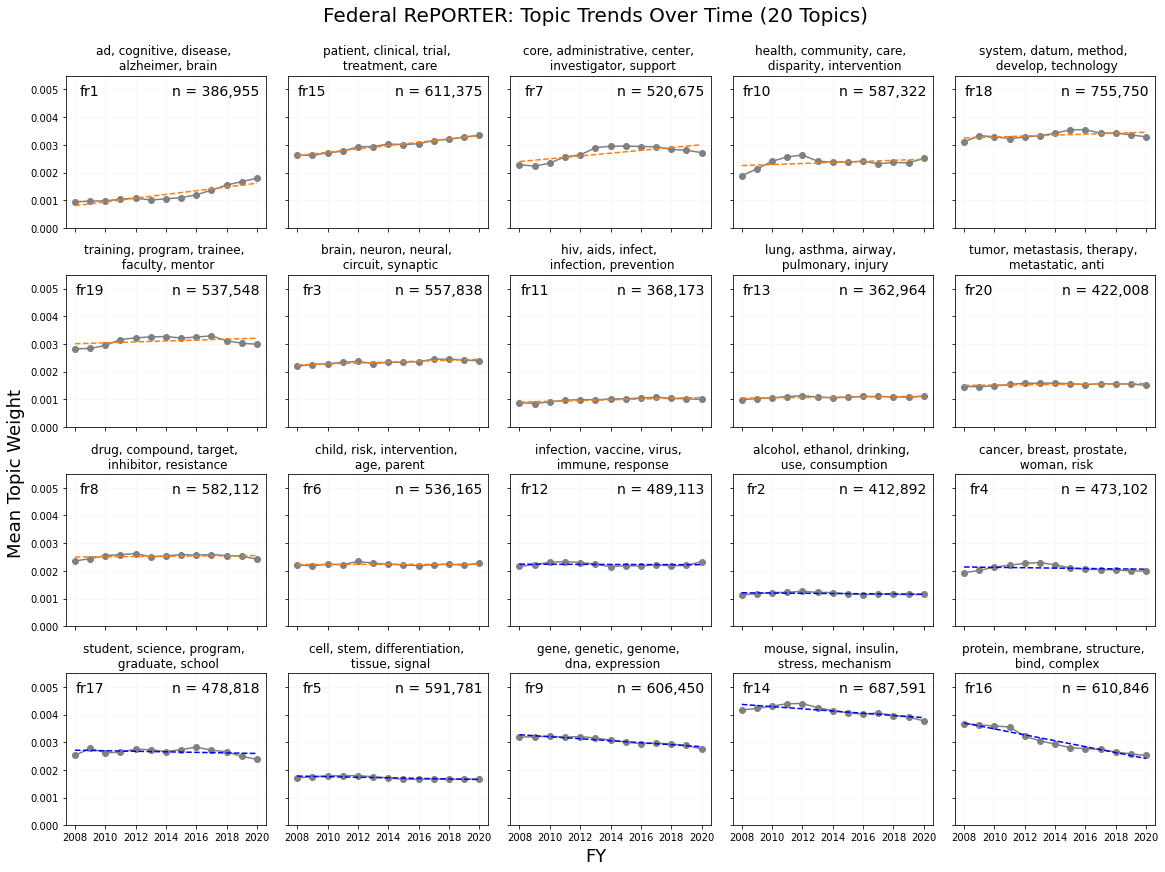

In [68]:
# set up grid
fig, ax = plt.subplots(4, 5, sharex = True, sharey = True, figsize=(16,12))
plt.ylim(bottom = 0.000, top = 0.0055) 
plt.xticks(np.arange(2008,2021,2))

# create plot in each grid square
for count,col_idx in enumerate(sorted_slopes[:25]):
    
    col = topic_wts_filt.columns[col_idx+1]
    
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    linear_fit = stats.linregress(topic_wts_filt["FY"].values, topic_wts_filt[col].values)
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.slope > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    if(count in []): # upward trend in 2020
        line_color = 'black'
    else: # downward trend in 2020
        line_color = 'gray'
    
    ax[i,j].errorbar(topic_wts_filt["FY"], topic_wts_filt[col], 
            yerr = np.array(topic_wts_se_filt[col]), fmt = '-o', color = line_color, zorder = 10) 
    
    ax[i,j].plot(topic_wts_filt["FY"], \
        (topic_wts_filt["FY"]*linear_fit.slope)+linear_fit.intercept, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[i,j].grid(color = "whitesmoke")
    
    # add annotations - number of nonzero project topic weights per point
    #for k, txt in enumerate(topic_counts_filt[col]):
    #    ax[i,j].annotate(txt, xy = (topic_wts_2010_2019["START_YEAR"][k+25], topic_wts_2010_2019[col][k+25]), \
    #                    xycoords = 'data', xytext = (1,8), textcoords = "offset points")

    # put legend on two lines for topics 17, 21
    #if count == 16:
    #    ax[i,j].set_title('interagency_agreement_niaid, \n avian_influenza, basic, swine, pathogenic', \
    #                      fontsize = 12)
    #elif count == 27:
    #    ax[i,j].set_title('poultry, transmission, \n avian_influenza_virus, raptor, bird', fontsize = 12)
    #else:
    ax[i,j].set_title(new_leg[col_idx], fontsize = 12)
    
    # add topic number to each plot
    ax[i,j].text(0.12, 0.90, str(L_df['Label'].iloc[col_idx]), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    # add number of documents including topic to each plot - should this be dominant topic only? or some threshold?
    ax[i,j].text(0.75, 0.90, "n = " + f"{n_by_topic[col_idx]:,}", horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    
fig.suptitle('Federal RePORTER: Topic Trends Over Time (20 Topics)', fontsize = 20)
fig.text(0.5, -0.003, 'FY', ha='center', va='center', fontsize = 18)
fig.text(-0.003, 0.44, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 18) #0.45
fig.tight_layout()
fig.subplots_adjust(top=0.90)

plt.savefig("./figures/full_20topic_trends.png", dpi = 800, bbox_inches = "tight")
plt.savefig("./figures/full_20topic_trends.pdf", dpi = 800, bbox_inches = "tight")
plt.show()

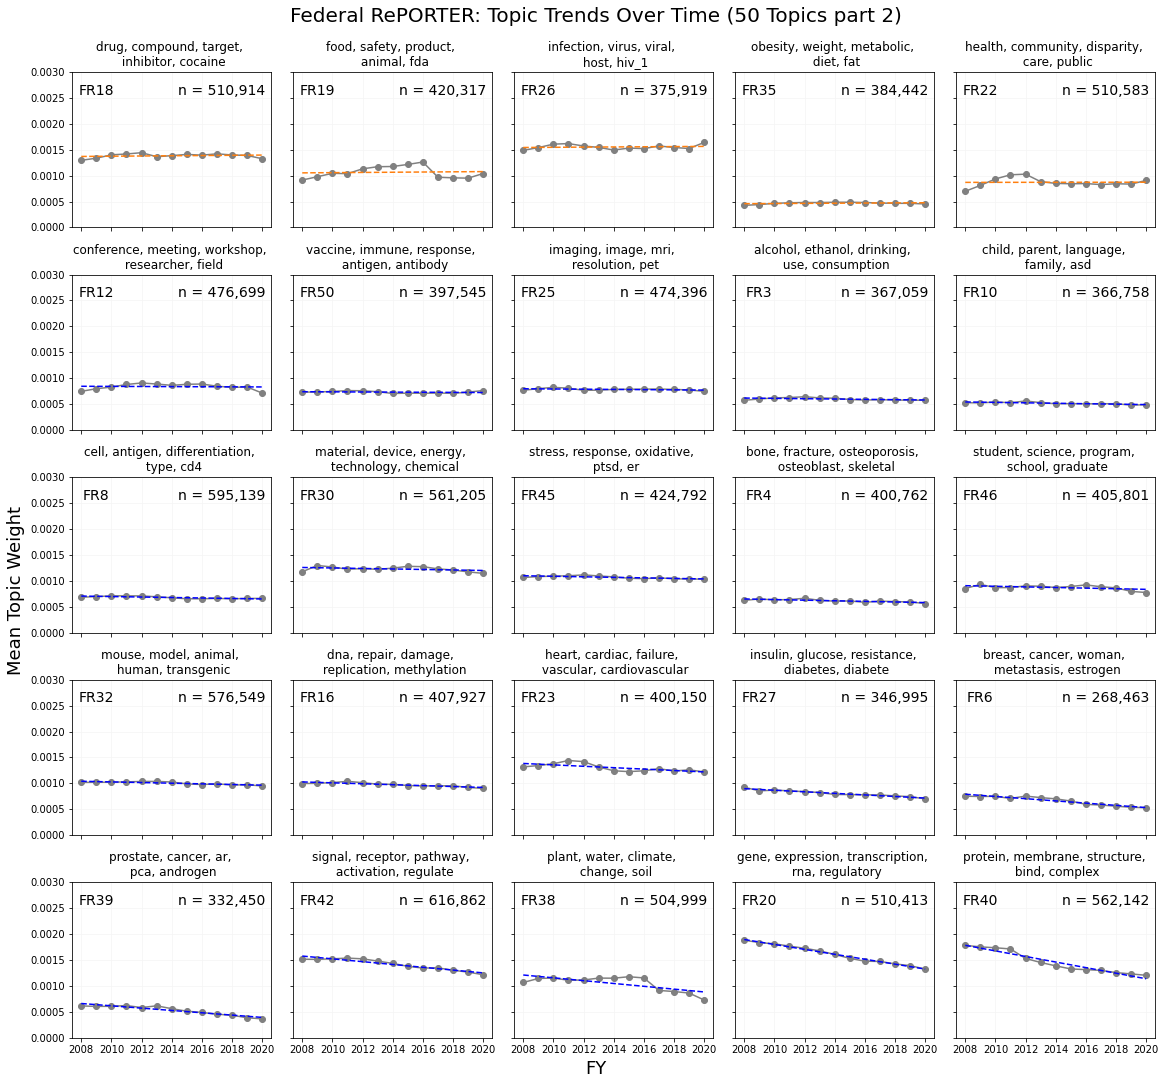

In [118]:
# set up grid
fig, ax = plt.subplots(5, 5, sharex = True, sharey = True, figsize=(16,15))
plt.ylim(bottom = 0.000, top = 0.003) 
plt.xticks(np.arange(2008,2021,2))

# create plot in each grid square
for count,col_idx in enumerate(sorted_slopes[25:]):
    
    col = topic_wts_filt.columns[col_idx+1]
    
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    linear_fit = stats.linregress(topic_wts_filt["FY"].values, topic_wts_filt[col].values)
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.slope > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    if(count in []): # upward trend in 2020
        line_color = 'black'
    else: # downward trend in 2020
        line_color = 'gray'
    
    ax[i,j].errorbar(topic_wts_filt["FY"], topic_wts_filt[col], 
            yerr = np.array(topic_wts_se_filt[col]), fmt = '-o', color = line_color, zorder = 10) 
    
    ax[i,j].plot(topic_wts_filt["FY"], \
        (topic_wts_filt["FY"]*linear_fit.slope)+linear_fit.intercept, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[i,j].grid(color = "whitesmoke")
    
    # add annotations - number of nonzero project topic weights per point
    #for k, txt in enumerate(topic_counts_filt[col]):
    #    ax[i,j].annotate(txt, xy = (topic_wts_2010_2019["START_YEAR"][k+25], topic_wts_2010_2019[col][k+25]), \
    #                    xycoords = 'data', xytext = (1,8), textcoords = "offset points")

    # put legend on two lines for topics 17, 21
    #if count == 16:
    #    ax[i,j].set_title('interagency_agreement_niaid, \n avian_influenza, basic, swine, pathogenic', \
    #                      fontsize = 12)
    #elif count == 27:
    #    ax[i,j].set_title('poultry, transmission, \n avian_influenza_virus, raptor, bird', fontsize = 12)
    #else:
    ax[i,j].set_title(new_leg[col_idx], fontsize = 12)
    
    # add topic number to each plot
    ax[i,j].text(0.12, 0.88, str(L_df['Label'].iloc[col_idx]), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    # add number of documents including topic to each plot - should this be dominant topic only? or some threshold?
    ax[i,j].text(0.75, 0.88, "n = " + f"{n_by_topic[col_idx]:,}", horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    
fig.suptitle('Federal RePORTER: Topic Trends Over Time (50 Topics part 2)', fontsize = 20)
fig.text(0.5, -0.003, 'FY', ha='center', va='center', fontsize = 18)
fig.text(-0.003, 0.44, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 18) #0.45
fig.tight_layout()
fig.subplots_adjust(top=0.92)

#plt.savefig("./figures/full_50topic_trends2.png", dpi = 800, bbox_inches = "tight")
#plt.savefig("./figures/full_50topic_trends2.pdf", dpi = 800, bbox_inches = "tight")
plt.show()